# Vision Transformer for Noise Classification

## Imports

In [1]:
%pip install jax flax optax matplotlib tqdm torch pillow torchvision numpy --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import jax
import jax.numpy as jnp

import flax
import flax.linen as nn
from jax import random
from flax.training.train_state import TrainState

import optax

import numpy as np

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt

from typing import Any, Optional
from tqdm import tqdm
import os

## Vision Transformer

In [2]:
class MLPBlock(nn.Module):
  hidden_size: int

  @nn.compact
  def __call__(self, x):

    output_shape =  x.shape[-1]

    x = nn.Dense(features=self.hidden_size)(x)
    x = nn.gelu(x)
    x = nn.Dense(features=output_shape)(x)

    return x

class EncoderBlock(nn.Module):
  n_heads: int
  input_size: int
  mlp_size: int

  @nn.compact
  def __call__(self, x):
    y = nn.LayerNorm(name='input_norm')(x)
    y = nn.MultiHeadDotProductAttention(num_heads=self.n_heads)(x)
    x = x + y
    norm_output = nn.LayerNorm(name='attention_norm')(x)
    y = MLPBlock(hidden_size=self.mlp_size)(x)
    return x + y

class VisionTransformer(nn.Module):
    n_layers: int
    n_heads: int
    n_classes: int
    mlp_size: int
    patch_size: int

    @nn.compact
    def __call__(self, image):
        patch_size = self.patch_size

        H, W, C = image.shape[1], image.shape[2], image.shape[3]
        n_patches = (H // patch_size) * (W // patch_size)

        image = image.reshape(image.shape[0], H // patch_size, patch_size, W // patch_size, patch_size, C)
        image = image.transpose(0, 1, 3, 2, 4, 5) # align successive pixels
        image = image.reshape(image.shape[0], n_patches, -1)

        embedding = nn.Dense(image.shape[-1])(image)

        pe = self.param('pos_embedding', nn.initializers.normal(), (1, n_patches, image.shape[-1]))
        x = embedding + pe

        for _ in range(self.n_layers):
            x = EncoderBlock(input_size=image.shape[-1],
                             n_heads=self.n_heads,
                             mlp_size=self.mlp_size)(x)

        x = nn.LayerNorm()(x)
        x = x.mean(axis=1)
        x = nn.Dense(self.n_classes)(x)

        return jax.nn.softmax(x)


## Dataset

In [3]:
class NoiseClassificationDataset(Dataset):
    """Noise classification dataset. Contains 64x64 samples from pseudorandom noises."""

    def __init__(self, directory='../noise_dataset'):
        self.directory = directory
        self.filenames = os.listdir(directory)
        self.noise_types = list(sorted(set([filename.rsplit('_', 1)[0]
                            for filename in self.filenames])))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        image = image.convert('L')  
        image = jnp.array(image).squeeze()
        image = jnp.expand_dims(image, -1)
        noise_type, _ = self.filenames[idx].rsplit('_', 1)
        label = jnp.zeros(len(self.noise_types))
        label.at[self.noise_types.index(noise_type)].set(1)
        return image, label
    
    def get_label_count(self):
        return len(set(self.noise_types))

image_shape=(64, 64, 1)
n_labels=5


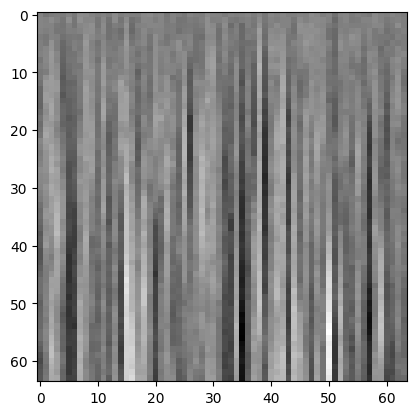

In [4]:
dataset = NoiseClassificationDataset()

image, label = dataset[0]
image_shape = image.shape
n_labels = dataset.get_label_count()

plt.imshow(image, cmap='gray')
print(f'{image_shape=}')
print(f'{n_labels=}')

In [5]:
dataset = NoiseClassificationDataset()

train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
eval_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4)

## Training

In [7]:
@jax.jit
def apply_model(state, inputs, labels):

    def loss_fn(params):
      eps = 1e-8
      logits = state.apply_fn(params, inputs)
      onehot = jax.nn.one_hot(labels, num_classes=5)
      loss = jnp.mean(optax.softmax_cross_entropy(logits, onehot)) + eps
      return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy


@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [8]:
def train_step(state, dataloader_train):
    epoch_loss = []
    epoch_accuracy = []

    for inputs, labels in tqdm(dataloader_train, position=0, leave=True):
      inputs = inputs.numpy().astype(np.float32)
      labels = labels.numpy().astype(np.float32)

      grads, loss, accuracy = apply_model(state, inputs, labels)
      state = update_model(state, grads)
      epoch_loss.append(loss)
      epoch_accuracy.append(accuracy)

    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy

In [9]:
def eval_step(state, dataloader_eval):
    epoch_loss = []
    epoch_accuracy = []

    for inputs, labels in dataloader_eval:
      inputs = inputs.numpy().astype(np.float32)
      labels = labels.numpy().astype(np.int32)

      _, loss, accuracy = apply_model(state, inputs, labels)
      epoch_loss.append(loss)
      epoch_accuracy.append(accuracy)

    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return train_loss, train_accuracy

In [10]:
def create_train_state(key, config):
    model = VisionTransformer(n_layers=6, n_heads=8,
                              n_classes=n_labels, mlp_size=256, patch_size=8)
    init_img = jnp.ones((1,) + image.shape)
    params = model.init(key, init_img)

    tx = optax.adam(config["learning_rate"])
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [11]:
def train_and_evaluate(state, config, dataloader_train, dataloader_eval):
    train_losses = []
    train_accuracies = []
    eval_losses = []
    eval_accuracies = []

    for epoch in range(1, config["n_epochs"] + 1):
        state, train_loss, train_accuracy = train_step(state, dataloader_train)
        eval_loss, eval_accuracy = eval_step(state, dataloader_eval)

        print(f' Epoch {epoch}: {eval_loss=}, {train_loss=}')

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

    return state, train_losses, train_accuracies, eval_losses, eval_accuracies

In [12]:
key = random.PRNGKey(0)

config = {
    "learning_rate": 1e-2,
    "n_epochs": 20
}

train_state = create_train_state(key, config)
_, tl, ta, el, ea = train_and_evaluate(
    train_state, config, train_loader, eval_loader)

  0%|          | 0/250 [00:00<?, ?it/s]